# Pressure-Velocity Coupling in a Reactor Model

This notebook demonstrates the initialization, solution, and visualization of a column reactor model with pressure-velocity coupling. The model incorporates the interaction between the flow field and reaction kinetics, providing a comprehensive simulation of the reactor's behavior under coupled pressure and velocity conditions.

The example showcases:
1. **Parameter Initialization**: Setting up the flow coupling model with specific parameters such as maximum function evaluations, molar masses of species, and dynamic viscosity.
2. **Model Solution**: Solving the column model to account for the integrated effects of flow dynamics and reaction kinetics.
3. **Result Visualization**: Generating 2D concentration fields and axial profiles for concentrations, axial velocity, and pressure to analyze the reactor's performance.

This approach allows for a detailed analysis of the concentration profiles, velocity, and pressure behavior within the reactor, providing insights into the complex interactions in the system.

Two classes are provided, namely, `ConvectionDiffusionReaction2D` and `FlowCoupling`. 
The class `ConvectionDiffusionReaction2D` is highly customizable and can be used for a large range of reactor models. It has some special features that make it easier to change te velocity field, such as the method `set_velocity_field`. It also allows for specyfying an inflow flow-rate directly, rather than via a Danckwerts boundary conditions. The reason is that Danckwerts boundary conditions are a bit awkward when the inlet velocity can change and is not known. (You impose a flow rate rather than a velocity. The velocity follows from the pressure-velocity coupling).
The class `FlowCoupling` computes a velocity field. It is initialized with a `ConvectionDiffusionReaction2D` object. Then it assumes that the velocity in this model is determined by a Darcy type of relation. In the implementation the Ergun equation for the relation between superficial velocity and pressure gradient. The pressure is computed from the total mole balance, which is constructed by summing the mole balances specified in `ConvectionDiffusionReaction2D`. The Jacobian is extended with a contribution due to the Darcy-dependence of velocity on pressure.
A sequential iterative solution method is used, where the reactor is used to compute the change in composition. The flow-coupling provides an update of the total concentration (as computed from the pressure)


In [38]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.sparse import csc_array
import scipy.sparse.linalg as sla
from scipy.linalg import norm
from pymrm import construct_grad, construct_div, construct_convflux_upwind, construct_coefficient_matrix, interp_cntr_to_stagg_tvd, upwind, interp_cntr_to_stagg, interp_stagg_to_cntr, minmod, newton, numjac_local, non_uniform_grid

## `ConvectionDiffusionReaction2D` class

The `ConvectionDiffusionReaction2D` class simulates reaction-diffusion systems in a 2D cylindrical geometry with both axial and radial components. This class supports customization of reaction kinetics and boundary conditions, making it suitable for a wide range of chemical engineering applications.

### Purpose
This class models the behavior of chemical species within a cylindrical reactor, accounting for both diffusion and convection in the axial and radial directions. It allows for the integration of complex reaction kinetics and provides tools for setting up and solving the system using numerical methods.

### Usage
To use the `ConvectionDiffusionReaction2D` class, instantiate it with the desired grid dimensions and optionally provide initialization and boundary condition functions. Set the velocity fields, and then call the `solve` method to perform the simulation. After solving, the concentration field can be analyzed to understand the behavior of the system over time.

### Example
```python
def init_params(model):
    model.shape_c = (100, 50, 1)
    model.eps_b = 0.5
    model.D_ax = 1e-5
    model.D_rad = 1e-5
    model.u_ax = 0.01
    model.flow_in = model.u_ax * 10.0
    model.kinetics = lambda c: -0.01 * c

def set_boundary_conditions(model):
    model.bc_ax = {'a': [0, 1], 'b': [0, 0], 'd': [0, 0]}
    model.bc_rad = {'a': [1, 1], 'b': [0, 0], 'd': [0, 0]}

model = ConvectionDiffusionReaction2D(init_params=init_params, set_bc=set_boundary_conditions)
model.solve(num_timesteps=100)

# Analyze the concentration field
plt.plot(model.z_c, model.c[:,0,0])
plt.xlabel('Axial Position (z)')
plt.ylabel('Concentration')
plt.title('Concentration Profile')
plt.show()

In [39]:
class ConvectionDiffusionReaction2D:
    """
    Class for simulating reaction-diffusion systems in a 2D cylindrical geometry with axial and radial components.

    Attributes:
    shape_c (tuple): Dimensions of the concentration grid (z, r, species).
    nu (float): Reaction rate coefficient.
    eps_b (float): Bed porosity.
    u_ax (float): Axial velocity.
    D_ax (float): Axial diffusion coefficient.
    L (float): Length of the reactor.
    D_rad (float): Radial diffusion coefficient.
    u_rad (float): Radial velocity.
    R (float): Radius of the reactor.
    flow_in (float): Flow rate at the inlet.
    dt (float): Time step (infinity for steady state).
    maxfev (int): Maximum number of function evaluations in the solver.
    kinetics (callable): Kinetics model function.
    react (callable): Function to compute reaction term and its Jacobian.
    c0 (float): Initial concentration value.
    c (numpy.ndarray): Concentration field.
    z_f (numpy.ndarray): Axial face grid points.
    z_c (numpy.ndarray): Axial center grid points.
    r_f (numpy.ndarray): Radial face grid points.
    r_c (numpy.ndarray): Radial center grid points.
    dA_r (numpy.ndarray): Differential area in the radial direction.
    bc_ax (dict): Axial boundary conditions.
    bc_rad (dict): Radial boundary conditions.
    Jac_accum (scipy.sparse.csc_matrix): Accumulation matrix for Jacobian.
    Div_ax (scipy.sparse.csc_matrix): Divergence matrix for axial direction.
    Flux_diff_ax (scipy.sparse.csc_matrix): Diffusion flux matrix for axial direction.
    flux_diff_ax_bc (numpy.ndarray): Inhomogeneous diffusion flux contribution for axial direction.
    g_const (numpy.ndarray): Constant term in the residual.
    Jac_const (scipy.sparse.csc_matrix): Constant part of the Jacobian matrix.
    Flux_diff_rad (scipy.sparse.csc_matrix): Diffusion flux matrix for radial direction.
    flux_diff_rad_bc (numpy.ndarray): Inhomogeneous diffusion flux contribution for radial direction.
    Conv_ax (scipy.sparse.csc_matrix): Convection matrix for axial direction.
    conv_ax_bc (numpy.ndarray): Axial convection boundary conditions.
    Conv_rad (scipy.sparse.csc_matrix): Convection matrix for radial direction.
    conv_rad_bc (numpy.ndarray): Radial convection boundary conditions.
    Jac_lin (scipy.sparse.csc_matrix): Linear part of the Jacobian matrix.
    g_conv_bc (numpy.ndarray): Convection boundary conditions term in the residual.
    """

    def __init__(self, init_params=None, set_bc=None):
        """
        Initialize the ConvectionDiffusionReaction2D class for simulating 
        reaction-diffusion systems in a 2D cylindrical geometry with axial and radial components.

        Parameters:
        - init_params (function): Optional function to initialize model parameters.
        - set_bc (function): Optional function to set boundary conditions.

        The model supports customization of reaction kinetics and boundary conditions,
        making it suitable for a wide range of chemical engineering applications.
        """
        self.shape_c = (1, 1, 1)  # Grid shape
        self.nu = 1
        self.eps_b = 0.4  # Bed porosity
        self.u_ax = 0     # Axial superficial velocity
        self.D_ax = 0.0   # Axial diffusion coefficient
        self.L = 1.0      # Length of the reactor
        self.D_rad = 0.0  # Radial diffusion coefficient
        self.u_rad = 0.0  # Radial superficial velocity
        self.R = 0.1      # Radius of the reactor
        self.flow_in = 0.1 * math.pi * self.R * self.R  # Inlet flow rate
        self.dt = 1e-2    # Time step (inf for steady state)
        self.maxfev = 2   # Maximum function evaluations in the solver
        self.kinetics = None  # Kinetics model
        self.react = None     # Reaction term function
        self.c0 = 0.0     # Initial concentration value

        # Optional parameter initialization
        if init_params is not None:
            init_params(self)

        # Initialize the concentration field
        self.init_field(self.c0)

        # Setup axial and radial grids
        self.z_f = non_uniform_grid(0, self.L, self.shape_c[0] + 1, 1.5 * self.L / self.shape_c[0], 1.4)
        self.z_c = 0.5 * (self.z_f[:-1] + self.z_f[1:])
        self.r_f = np.linspace(0, self.R, self.shape_c[1] + 1)
        self.r_c = 0.5 * (self.r_f[:-1] + self.r_f[1:])
        r_sq = self.r_f * self.r_f
        self.dA_r = (r_sq[1:] - r_sq[:-1]) * math.pi # area of rings. Useful for averaging.

        # Setup boundary conditions for axial and radial directions
        self.bc_ax = {'a': [0, 1], 'b': [0, 0], 'd': [0, 0]}
        self.bc_rad = {'a': [1.0, 1.0], 'b': [0, 0], 'd': [0, 0]}

        # Optional boundary condition customization
        if set_bc is not None:
            set_bc(self)

        # Initialize Jacobian matrices for the system
        self.init_Jac()
        self.set_velocity_field(self.u_ax, self.u_rad)

    def init_field(self, c0=0.0):
        """
        Initialize the concentration field.

        Parameters:
        - c0 (float): Initial concentration value.
        """
        self.c = np.broadcast_to(np.array(c0), self.shape_c).copy()

    def init_Jac(self):
        """
        Initialize the Jacobian matrices for the system. 
        This includes setting up the accumulation, convection, and diffusion terms.
        """
        self.Jac_accum = construct_coefficient_matrix(self.eps_b / self.dt, self.c.shape)

        # Axial gradient and flux matrices
        Grad, grad_bc = construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        self.Div_ax = construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        self.Flux_diff_ax = -self.D_ax * Grad
        self.flux_diff_ax_bc = -self.D_ax * grad_bc
        self.g_const = self.Div_ax @ self.flux_diff_ax_bc
        self.Jac_const = self.Jac_accum + self.Div_ax @ self.Flux_diff_ax

        # Radial gradient and flux matrices
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc_rad, axis=1)
        self.Div_rad = construct_div(self.c.shape, self.r_f, nu=self.nu, axis=1)
        self.Flux_diff_rad = -self.D_rad * Grad
        self.flux_diff_rad_bc = -self.D_rad * grad_bc
        self.g_const += self.Div_rad @ self.flux_diff_rad_bc
        self.Jac_const += self.Div_rad @ self.Flux_diff_rad

    def set_velocity_field(self, u_ax, u_rad):
        """
        Set the velocity field for the axial and radial directions.

        Parameters:
        - u_ax (float or numpy.ndarray): Axial velocity.
        - u_rad (float or numpy.ndarray): Radial velocity.
        """
        shape = list(self.shape_c)
        shape[0] += 1
        self.u_ax = np.broadcast_to(u_ax, shape)
        shape = list(self.shape_c)
        shape[1] += 1
        self.u_rad = np.broadcast_to(u_rad, shape)
        self.Conv_ax, self.conv_ax_bc = construct_convflux_upwind(self.shape_c, self.z_f, self.z_c, self.bc_ax, self.u_ax, axis=0)
        flux_in = np.broadcast_to(np.array(self.flow_in).reshape((1, 1, -1)) / (math.pi * (self.r_f[-1]*self.r_f[-1]-self.r_f[0]*self.r_f[0])), (1,*self.shape_c[1:]))
        self.conv_ax_bc[0:flux_in.size, [0]] = self.conv_ax_bc[0:flux_in.size, [0]] + flux_in.reshape((-1, 1))
        self.Conv_rad, self.conv_rad_bc = construct_convflux_upwind(self.shape_c, self.r_f, self.r_c, self.bc_rad, self.u_rad, axis=1)
        self.Jac_lin = self.Jac_const + self.Div_ax @ self.Conv_ax + self.Div_rad @ self.Conv_rad
        self.g_conv_bc = self.Div_ax @ self.conv_ax_bc + self.Div_rad @ self.conv_rad_bc

    def construct_g(self, c, c_old):
        """
        Construct the residual vector g and the Jacobian matrix for the system.

        Parameters:
        - c (numpy.ndarray): Current concentration field.
        - c_old (numpy.ndarray): Previous concentration field.

        Returns:
        - g (numpy.ndarray): Residual vector.
        - Jac (scipy.sparse.csc_matrix): Jacobian matrix.
        """
        c_f, dc_f = interp_cntr_to_stagg_tvd(c, self.z_f, self.z_c, self.bc_ax, self.u_ax, minmod, axis=0)
        dg_conv = self.Div_ax @ (self.u_ax * dc_f).reshape((-1, 1))
        c_f, dc_f = interp_cntr_to_stagg_tvd(c, self.r_f, self.r_c, self.bc_rad, self.u_rad, minmod, axis=1)
        dg_conv = dg_conv + self.Div_rad @ (self.u_rad * dc_f).reshape((-1, 1))

        if self.kinetics is not None:
            g_react, Jac_react = numjac_local(self.kinetics, c)
        else:
            g_react = np.array([0])
            Jac_react = 0.0

        if self.react is not None:
            g_react2, Jac_react2 = self.react(c)
            g_react = g_react + g_react2
            Jac_react = Jac_react + Jac_react2

        c_vec = c.reshape((-1, 1))
        c_old_vec = c_old.reshape((-1, 1))
        g = self.g_const + self.g_conv_bc + dg_conv + self.Jac_lin @ c_vec - self.Jac_accum @ c_old_vec - (1.0 - self.eps_b) * g_react.reshape((-1, 1))
        Jac = self.Jac_lin - (1.0 - self.eps_b) * Jac_react
        return g, Jac

    def solve(self, num_timesteps=1):
        """
        Solve the system for a specified number of time steps.

        Parameters:
        - num_timesteps (int): Number of time steps to solve for.
        """
        for i in range(num_timesteps):
            c_old = self.c.copy()  # Copy the current concentration field
            result = newton(lambda c: self.construct_g(c, c_old), c_old, maxfev=self.maxfev)
            self.c = result.x  # Update concentration field with the result from Newton's method


## `FlowCoupling` class

The `FlowCoupling` class integrates a reactor model with a flow model, allowing for the simulation of coupled flow and reaction-diffusion processes. This class is useful for scenarios where the flow field influences the reaction-diffusion behavior within the reactor.

### Purpose
The `FlowCoupling` class handles the interaction between the flow field and the reaction-diffusion processes in a reactor model. By solving the flow field alongside the reaction-diffusion equations, this class provides a more accurate representation of the system, especially in cases where flow-induced effects are significant.

### Usage
To use the `FlowCoupling` class, initialize it with a reactor model and optionally provide initialization functions for additional parameters. After setting up the model, call the `solve` method to perform the simulation. Post-simulation, the concentration field and flow characteristics can be analyzed to gain insights into the coupled system behavior.

### Example
```python
# Define initialization functions for parameters and boundary conditions
def init_params_column(model):
    model.shape_c = (100, 50, 3)
    model.eps_b = 0.4
    model.D_ax = 1e-5
    model.D_rad = 1e-5
    model.u_ax = 0.01
    model.flow_in = model.u_ax * 10.0
    model.kinetics = kinetics_A_to_B_and_C
    model.T = 300  # Temperature
    model.p = 101325  # Pressure at outlet

def set_bc_column(model):
    model.bc_ax = {'a': [0, 1], 'b': [0, 0], 'd': [0, 0]}
    model.bc_rad = {'a': [1.0, 1.0], 'b': [0, 0], 'd': [0, 0]}

def init_params_flow_coupling(model):
    model.visc = 1e-3
    model.d_p = 1e-3
    model.molar_mass = [[[34.016e-3, 18.016e-3, 32.00e-3]]]
    model.rm.maxfev = 5
    model.maxfev = 10  # The maximum number of iterations within a time step

# Initialize the column model with parameters and boundary conditions
column_model = ConvectionDiffusionReaction2D(
    init_params=init_params_column,
    set_bc=set_bc_column
)

# Initialize the FlowCoupling model
column_model_with_flow_coupling = FlowCoupling(column_model, init_params=init_params_flow_coupling)

# Solve the column model with flow coupling
column_model_with_flow_coupling.solve()

# Plot the 2D concentration fields for each component in the model
plot_model_2D(column_model_with_flow_coupling.rm)

# Plot axial profiles
plot_axial_profile(column_model_with_flow_coupling)

In [53]:
class FlowCoupling:
    """
    Class for coupling a reactor model with a flow model to simulate reaction-diffusion systems with variable velocity fields.

    Attributes:
    rm (ConvectionDiffusionReaction2D): The reactor model.
    maxfev (int): Maximum number of iterations within a time step.
    tol (float): Tolerance for convergence.
    shape_p (tuple): Shape of the pressure field (same as reactor model excluding species dimension).
    T (float): Temperature of the reactor.
    p_out (float): Outlet pressure.
    construct_DvDp_grad (function): Function to compute velocities from pressure gradients.
    visc (float): Viscosity of the fluid.
    d_p (float): Particle diameter.
    molar_mass (list): Molar masses of the components.
    is_mobile (range): Indices of mobile species.
    Sum (scipy.sparse.csc_array): Matrix that sums over species
    indcs_dcdp (range): Indices for constructing the DcDp matrix.
    indptr_dcdp (range): Pointer indices for constructing the DcDp matrix.
    Grad_p_ax (scipy.sparse.csc_array): Gradient matrix for axial pressure.
    grad_p_ax_bc (numpy.ndarray): Boundary condition contribution for axial pressure gradient.
    Div_p_ax (scipy.sparse.csc_array): Divergence matrix for axial pressure.
    Grad_p_rad (scipy.sparse.csc_array): Gradient matrix for radial pressure.
    grad_p_rad_bc (numpy.ndarray): Boundary condition contribution for radial pressure gradient.
    Div_p_rad (scipy.sparse.csc_array): Divergence matrix for radial pressure.
    u_ax (numpy.ndarray): Axial velocity field.
    u_rad (numpy.ndarray): Radial velocity field.
    p (numpy.ndarray): Pressure field.
    """

    def __init__(self, reactor_model, init_params=None):
        """
        Initialize the FlowCoupling class.

        Parameters:
        - reactor_model (ConvectionDiffusionReaction2D): The reactor model to be coupled with the flow model.
        - init_params (function, optional): Function to initialize additional parameters for the flow model.
        """
        self.rm = reactor_model
        self.maxfev = 5  # Maximum function evaluations for the solver
        self.tol = 1.49012e-08  # Convergence tolerance
        shape_c = self.rm.shape_c
        self.shape_p = shape_c[0:-1]  # Shape of the pressure field (excluding species dimension)
        self.T = reactor_model.T  # Temperature of the reactor
        self.p_out = reactor_model.p  # Outlet pressure
        self.construct_DvDp_grad = self.correlation_Ergun  # Function to compute velocity gradients from pressure gradients
        self.visc = 1e-3  # Viscosity of the fluid
        self.d_p = 1e-3  # Particle diameter
        self.molar_mass = 18e-3  # Molar masses of the components
        self.is_mobile = range(0, shape_c[-1])  # Indices of mobile species

        # Initialize additional parameters if provided
        if init_params is not None:
            init_params(self)

        # Initialize Jacobian matrices and pressure field
        self.init_Jac()
        self.init_pressure_field()

    def init_Jac(self):
        """
        Initialize the Jacobian matrices for the flow model. 
        This includes setting up the gradient and divergence matrices for both axial and radial directions.
        """
        shape_c = self.rm.shape_c
        num_c = shape_c[-1]
        size_p = math.prod(self.shape_p)
        size_c = size_p * shape_c[-1]
        indcs_sum = np.arange(size_p, dtype=int).repeat(shape_c[-1])
        indptr_sum = range(math.prod(shape_c) + 1)
        self.Sum = csc_array((np.ones(size_c), indcs_sum, indptr_sum), shape=(size_p, size_c))
        self.indcs_dcdp = range(math.prod(shape_c))
        self.indptr_dcdp = range(0, math.prod(shape_c) + num_c, num_c)

        # Axial pressure gradient and divergence matrices
        bc_p = {'a': [0, 0], 'b': [0, 1], 'd': [0, self.p_out]}
        self.Grad_p_ax, self.grad_p_ax_bc = construct_grad(self.shape_p, self.rm.z_f, self.rm.z_c, bc=bc_p, axis=0)
        self.Div_p_ax = construct_div(self.shape_p, self.rm.z_f, nu=0, axis=0)

        # Radial pressure gradient and divergence matrices
        bc_p = {'a': [0, 0], 'b': [0, 0], 'd': [0, 0]}
        self.Grad_p_rad, self.grad_p_rad_bc = construct_grad(self.shape_p, self.rm.r_f, self.rm.r_c, bc=bc_p, axis=1)
        self.Div_p_rad = construct_div(self.shape_p, self.rm.r_f, nu=self.rm.nu, axis=1)

        # Initialize velocity fields
        shape_u = list(self.shape_p)
        shape_u[0] += 1
        self.u_ax = np.zeros(shape_u)
        shape_u = list(self.shape_p)
        shape_u[1] += 1
        self.u_rad = np.zeros(shape_u)

    def init_pressure_field(self):
        """
        Initialize the pressure field and solve for the initial velocity field.
        """
        c = self.rm.c
        molfrac = c / np.sum(c, axis=-1, keepdims=True)
        self.p = np.broadcast_to(np.array(self.p_out), self.shape_p)
        self.set_velocity_field(self.p, molfrac)
        result = newton(lambda p: self.construct_g_p(p, molfrac, c), self.p, maxfev=1, callback=lambda p, g_p: self.set_velocity_field(p, molfrac))
        self.p = result.x

    def correlation_Ergun(self, c, eps_b):
        """
        Compute the Ergun correlation for the velocity field based on the concentration and bed porosity.

        Parameters:
        - c (numpy.ndarray): Concentration field.
        - eps_b (float): Bed porosity.

        Returns:
        - DvDgrad_p_ax (scipy.sparse.csc_array): Coefficient matrix for axial velocity gradient.
        - DvDgrad_p_rad (scipy.sparse.csc_array): Coefficient matrix for radial velocity gradient.
        """
        r_c = self.rm.r_c
        r_f = self.rm.r_f
        z_c = self.rm.z_c
        z_f = self.rm.z_f
        eps_b_3 = eps_b * eps_b * eps_b
        eps_s = 1.0 - eps_b
        rho = np.sum((c * self.molar_mass), axis=-1)
        u_ax_cntr = interp_stagg_to_cntr(self.u_ax, z_f, z_c, axis=0)
        u_rad_cntr = interp_stagg_to_cntr(self.u_rad, r_f, r_c, axis=1)
        v_magn = np.sqrt(u_rad_cntr * u_rad_cntr + u_ax_cntr * u_ax_cntr)
        beta = eps_s / eps_b_3 * (eps_s * (150.0 * self.visc / (self.d_p * self.d_p)) + (1.75 * rho / self.d_p * v_magn))
        beta_ax = interp_cntr_to_stagg(beta, z_f, z_c, axis=0)
        beta_rad = interp_cntr_to_stagg(beta, r_f, r_c, axis=1)
        DvDgrad_p_ax = construct_coefficient_matrix(-1.0 / beta_ax)
        DvDgrad_p_rad = construct_coefficient_matrix(-1.0 / beta_rad)
        return DvDgrad_p_ax, DvDgrad_p_rad

    def construct_DcDp(self, c_tot, molfrac):
        """
        Construct the derivative of concentration with respect to pressure.

        Parameters:
        - c_tot (numpy.ndarray): Total concentration field.
        - molfrac (numpy.ndarray): Molar fraction field.

        Returns:
        - DcDp (scipy.sparse.csc_array): Derivative of concentration with respect to pressure.
        """
        T_field = np.array(self.T)
        shapeT = T_field.shape + (1,) * (molfrac.ndim - T_field.ndim)
        T_field = T_field.reshape(shapeT)
        dcdp_field = molfrac / (sp.constants.R * T_field)
        DcDp = sp.sparse.csc_array((dcdp_field.ravel(), self.indcs_dcdp, self.indptr_dcdp), shape=(molfrac.size, math.prod(molfrac.shape[0:-1])))
        return DcDp

    def set_velocity_field(self, p, molfrac):
        """
        Set the velocity field based on the pressure field and molar fractions.

        Parameters:
        - p (numpy.ndarray): Pressure field.
        - molfrac (numpy.ndarray): Molar fraction field.
        """
        T_field = np.array(self.T)
        shapeT = T_field.shape + (1,) * (p.ndim - T_field.ndim)
        T_field = T_field.reshape(shapeT)
        c_tot = p / (sp.constants.R * T_field)
        c = molfrac * c_tot[..., np.newaxis]
        DvDgrad_p_ax, DvDgrad_p_rad = self.construct_DvDp_grad(c, self.rm.eps_b)
        p_vec = p.reshape((-1, 1))
        shape_u_ax = list(self.shape_p)
        shape_u_ax[0] += 1
        z_f = self.rm.z_f
        shape_c = self.rm.shape_c
        self.u_ax = (DvDgrad_p_ax @ (self.Grad_p_ax @ p_vec + self.grad_p_ax_bc)).reshape(shape_u_ax)
        self.u_ax[0, :] = ((z_f[2] - z_f[0]) * self.u_ax[1, :] - self.u_ax[2, :] * (z_f[1] - z_f[0])) / (z_f[2] - z_f[1])
        shape_u_rad = list(self.shape_p)
        shape_u_rad[1] += 1
        self.u_rad = (DvDgrad_p_rad @ (self.Grad_p_rad @ p_vec + self.grad_p_rad_bc)).reshape(shape_u_rad)
        if len(self.is_mobile) == shape_c[-1]:
            u_ax = self.u_ax[..., np.newaxis]
            u_rad = self.u_rad[..., np.newaxis]
        else:
            u_ax = np.zeros((*shape_u_ax, shape_c[-1]))
            u_ax[..., self.is_mobile] = np.tile(self.u_ax[..., np.newaxis], ((1,) * (u_ax.ndim - 1) + (len(self.is_mobile),)))
            u_rad = np.zeros((*shape_u_rad, shape_c[-1]))
            u_rad[..., self.is_mobile] = np.tile(self.u_rad[..., np.newaxis], ((1,) * (u_rad.ndim - 1) + (len(self.is_mobile),)))       
        self.rm.set_velocity_field(u_ax, u_rad) # set the velocity field in the reactor model
                        
    def construct_Jac_p_darcy(self, c):
        """
        Construct the Jacobian matrix contribution for the Darcy flow part.

        Parameters:
        - c (numpy.ndarray): Concentration field.

        Returns:
        - Jac_p_darcy (scipy.sparse.csc_array): Jacobian matrix for the Darcy flow equation.
        """
        DvDgrad_p_ax, DvDgrad_p_rad = self.construct_DvDp_grad(c, self.rm.eps_b)
        z_f = self.rm.z_f
        c_ax, _ = interp_cntr_to_stagg_tvd(c, z_f, self.rm.z_c, self.rm.bc_ax, self.rm.u_ax, minmod, axis=0)
        c_ax = np.sum(c_ax, axis=-1)
        C_f = construct_coefficient_matrix(c_ax)
        Jac_p_darcy = self.Div_p_ax @ C_f @ DvDgrad_p_ax @ self.Grad_p_ax
        c_rad, _ = interp_cntr_to_stagg_tvd(c, self.rm.r_f, self.rm.r_c, self.rm.bc_rad, self.rm.u_rad, minmod, axis=1)
        c_rad = np.sum(c_rad, axis=-1)
        C_f = construct_coefficient_matrix(c_rad)
        Jac_p_darcy += self.Div_p_rad @ C_f @ DvDgrad_p_rad @ self.Grad_p_rad
        return Jac_p_darcy
    
    def construct_g_p(self, p, molfrac, c_old):
        """
        Construct the residual vector and Jacobian matrix for the pressure equation.

        Parameters:
        - p (numpy.ndarray): Pressure field.
        - molfrac (numpy.ndarray): Molar fraction field.
        - c_old (numpy.ndarray): Previous concentration field.

        Returns:
        - g_p (numpy.ndarray): Residual vector for the pressure equation.
        - Jac_p (scipy.sparse.csc_array): Jacobian matrix for the pressure equation.
        """
        T_field = np.array(self.T)
        shapeT = T_field.shape + (1,) * (p.ndim - T_field.ndim)
        T_field = T_field.reshape(shapeT)
        c_tot = p / (sp.constants.R * T_field)
        c = molfrac * c_tot[..., np.newaxis]
        g, Jac = self.rm.construct_g(c, c_old)
        g_p = self.Sum @ g.reshape((-1, 1))
        DcDp = self.construct_DcDp(c_tot, molfrac)
        Jac_p = self.Sum @ Jac @ DcDp
        Jac_p_darcy = self.construct_Jac_p_darcy(c)
        Jac_p += Jac_p_darcy
        return g_p, Jac_p
    
    def solve(self, num_timesteps=1):
        """
        Solve the coupled reactor-flow system for a specified number of time steps.

        Parameters:
        - num_timesteps (int): Number of time steps to solve for.
        """
        shape_c = self.rm.shape_c
        c = self.rm.c
        c_tot = self.p / (sp.constants.R * self.T)  # Total concentration field
        molfrac = c / np.sum(c, axis=-1, keepdims=True)
        c_iter = molfrac * c_tot[..., np.newaxis]
        
        for i in range(num_timesteps):
            c_old = c.copy()
            converged = False
            it = 0
            
            while (not converged) and (it < self.maxfev):
                c = c_iter
                result = newton(lambda c: self.rm.construct_g(c, c_old), c, maxfev=self.rm.maxfev)
                c = result.x
                molfrac = c / np.sum(c, axis=-1, keepdims=True)
                c = molfrac * c_tot[..., np.newaxis]

                result = newton(lambda p: self.construct_g_p(p, molfrac, c_old), self.p, maxfev=1, callback=lambda p, g_p: self.set_velocity_field(p, molfrac))
                self.p = result.x
                c_tot = self.p / (sp.constants.R * self.T)
                c_iter = molfrac * c_tot[..., np.newaxis]
                dc = c_iter - self.rm.c
                self.rm.c = c_iter

                error_est = norm(dc.ravel(), ord=np.inf)
                converged = error_est < self.tol
                it += 1

## Example Kinetics

The following example demonstrates a kinetic model for a 3-component system involving the reactions A  → B + C. 

The kinetic model is defined as follows:

In [41]:
def kinetics_A_to_B_plus_C(c):
    """
    Compute the reaction rates for a 3-component system involving the reactions A → B + 0.5 C.

    Parameters:
    - c (numpy.ndarray): Concentration array with the last dimension corresponding to the components [A, B, C].

    Returns:
    - r (numpy.ndarray): Reaction rate array with the same shape as the input concentration array.
    """
    k = 0.1  # Rate constant for A  → B + 0.5 C

    # Initialize the reaction rate array with the same shape as c
    r = np.empty_like(c)

    # Calculate the net reaction rates for each component
    rate = k*c[...,0]
    r[...,0] = -rate
    r[...,1] =  rate
    r[...,2] =  0.5*rate

    return r


Plotting functions used in the examples below.

In [42]:
import string

def plot_model_2D(model):
    """
    Plot the 2D concentration fields of a multi-component model.

    This function creates a 2D plot for each component of the concentration field
    in the given model. Each plot is displayed as a separate subplot in a single figure.

    Parameters:
    - model: An object containing the concentration field and grid information. 
      The model is expected to have the following attributes:
        - model.shape_c: A tuple representing the shape of the concentration field array.
        - model.r_f: Radial face grid points.
        - model.z_f: Axial face grid points.
        - model.c: Concentration field array with the last dimension corresponding to components.
    """
    # Number of components in the concentration field
    num_c = model.shape_c[-1]

    labels = list(string.ascii_uppercase[:num_c])
    # Create a figure with subplots for each component
    fig, axes = plt.subplots(nrows=1, ncols=num_c, figsize=(4 * num_c, 3))

    # Ensure axes is always a list, even if there is only one component
    if num_c == 1:
        axes = [axes]

    # Initialize a list to store the contour plots
    contours = [None] * num_c

    # Iterate over each component and create a pcolormesh plot
    for idx, ax in enumerate(axes):
        contour = ax.pcolormesh(model.r_f, model.z_f, model.c[:, :, idx], shading='flat', cmap='viridis', vmin=0)
        contours[idx] = contour  # Store the contour plot
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xticklabels([])  # Remove x-axis labels
        ax.set_yticklabels([])  # Remove y-axis labels
        ax.set_title(f'Component {labels[idx]}')  # Set the title for each subplot

    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.92, axes[0].get_position().y0, 0.02, axes[0].get_position().y1 - axes[0].get_position().y0])
    plt.colorbar(contours[0], cax=cbar_ax)

    # Display the plot
    plt.show()

def plot_axial_profile(model):
    """
    Plot axial profiles for concentrations, axial velocity, and pressure (if available) one the centerline of the reactor.

    This function generates two or three plots side-by-side:
    1. Concentrations along the axial direction.
    2. Axial velocity profile.
    3. Pressure profile (if available).

    Parameters:
    - model: The reactor model object. If it has an attribute 'rm', it indicates a wrapper model, and pressure data will be plotted if available.

    The function includes legends for the concentration plots using labels ('A', 'B', etc.) and 'total' for the sum of concentrations.
    Each plot also includes appropriate axis labels.
    """
    if hasattr(model, 'rm'):
        num_plots = 3
        rm = model.rm
    else:
        num_plots = 2
        rm = model
        
    labels = list(string.ascii_uppercase[:rm.c.shape[-1]])
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(4 * num_plots, 3))
    
    # Plot concentration profiles
    for i in range(rm.c.shape[-1]):
        axes[0].plot(rm.z_c, rm.c[:, 0, i], '.-', label=labels[i])
    axes[0].plot(rm.z_c, np.sum(rm.c[:, 0, :], axis=-1), '.-', label='total')
    axes[0].set_xlabel('Axial Position (z)')
    axes[0].set_ylabel('Concentration')
    axes[0].legend()
    axes[0].set_title('Axial Centerline Concentration Profiles')
    
    # Plot axial velocity profile
    axes[1].plot(rm.z_f, rm.u_ax[:, 0, 0], '.-')
    axes[1].set_xlabel('Axial Position (z)')
    axes[1].set_ylabel('Axial Velocity')
    axes[1].set_title('Axial Centerline Velocity Profile')
    
    # Plot pressure profile if available
    if num_plots > 2:
        axes[2].plot(rm.z_c, model.p[:, 0], '.-')
        axes[2].set_xlabel('Axial Position (z)')
        axes[2].set_ylabel('Pressure')
        axes[2].set_title('Axial Centerline Pressure Profile')
    
    plt.tight_layout()
    plt.show()

## Reactor Model Initialization and Boundary Conditions

This example demonstrates the initialization of parameters and setting boundary conditions for a column reactor model without pressure-velocity coupling.

### `init_params_column(model)`
This function initializes the column reactor model with the following parameters:
- **Number of Components (`num_c`)**: Sets the number of chemical components.
- **Shape of Concentration Array (`model.shape_c`)**: Defines the spatial grid size and number of components.
- **Kinetic Model (`model.kinetics`)**: Specifies the reaction kinetics to be used.
- **Time-step (`model.dt`)**: Set to infinity for steady-state solutions.
- **Maximum Function Evaluations (`model.maxfev`)**: Sets the upper limit for function evaluations.
- **Pressure (`model.p`)**: Sets the operating pressure in Pascals.
- **Temperature (`model.T`)**: Sets the operating temperature in Kelvin.
- **Initial Concentration (`model.c0`)**: Computes the initial concentration using the ideal gas law.
- **Axial Velocity (`model.u_ax`)**: Specifies the axial flow velocity.
- **Radial Diffusion Coefficient (`model.D_rad`)**: Defines the diffusion coefficient in the radial direction.

### `set_bc_column(model)`
This function sets the boundary conditions for the column reactor model:
- **Radial Boundary Conditions (`model.bc_rad`)**:
  - Component A is removed at the wall (Dirichlet condition).
  - Components B and C follow Neumann boundary conditions (no flux).
- **Inlet Concentration (`c_in`)**: Calculates the concentration of component A at the inlet using the ideal gas law.
- **Flow Rate (`model.flow_in`)**: Computes the inlet flow rate based on the axial velocity and cross-sectional area.

Together, these functions configure the model for simulations, ensuring proper initialization and boundary conditions for accurate and stable results.


In [43]:
def init_params_column(model):
    """
    Initialize the parameters for the column model.

    This function sets the kinetic model, time-step, maximum number of function evaluations,
    initial concentration, and inlet concentration for the column model.

    Parameters:
    - model: An instance of the column model to be initialized.
    """
    # Define the number of components
    num_c = 3
    model.shape_c = (50, 20, num_c)  # Set the shape of the concentration array

    model.kinetics = kinetics_A_to_B_plus_C  # Set the kinetic model
    model.dt = np.inf  # Set time-step to infinity for steady-state solution
    model.maxfev = 5  # Set the maximum number of function evaluations

    # Set pressure and temperature
    model.p = 1e5  # Pressure in Pascals
    model.T = 293.15  # Temperature in Kelvin

    # Calculate the initial concentration based on ideal gas law
    c0 = model.p / (sp.constants.R * model.T)
    model.c0 = np.zeros((1, 1, num_c))
    model.c0[:, :, -1] = c0  # Set initial concentration for the last component

    # Set axial velocity and radial diffusion coefficient
    model.u_ax = 0.01  # Axial velocity in m/s
    model.D_rad = 1e-4  # Radial diffusion coefficient in m^2/s

def set_bc_column(model):
    """
    Set the boundary conditions for the column model.

    This function defines the radial boundary conditions for the column model.
    Component A is removed at the wall, while components B and C follow Neumann boundary conditions.

    Parameters:
    - model: An instance of the column model to set boundary conditions for.
    """
    # Define the boundary conditions
    model.bc_rad = {
        'a': [1, [[[1, 0, 1]]]],  # Neumann BC for components A and C at the wall
        'b': [0, [[[0, 1, 0]]]],  # Component B is removed at the tube wall
        'd': [0, 0]  # Homogeneous boundary conditions
    }

    # Set the inlet concentration
    num_c = model.shape_c[2]
    c_in = np.zeros((1, 1, num_c))
    c_in[:, :, 0] = model.p / (sp.constants.R * model.T)  # Inlet concentration for component A

    # Calculate the inlet flow rate based on the area and axial velocity
    area = math.pi * model.r_f[-1]**2  # Cross-sectional area of the column
    model.flow_in = model.u_ax * area * c_in  # Inlet concentration for the model

### Example: Steady-State Solution of the Column Model with Specified Kinetics

This example demonstrates how to compute a steady-state solution for the column model using the specified kinetics. The model is configured to simulate the reaction-diffusion process under steady-state conditions, utilizing the kinetic parameters and boundary conditions defined earlier.


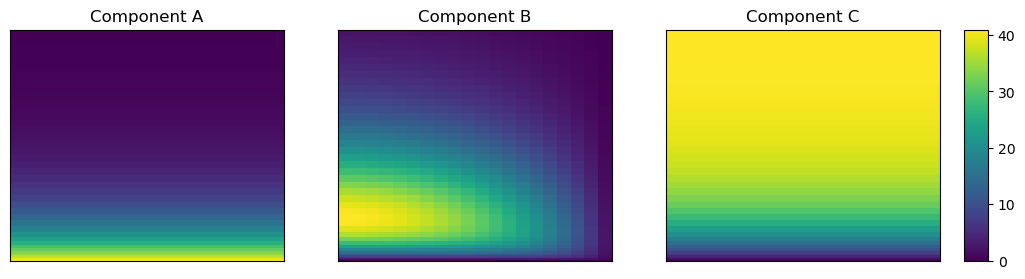

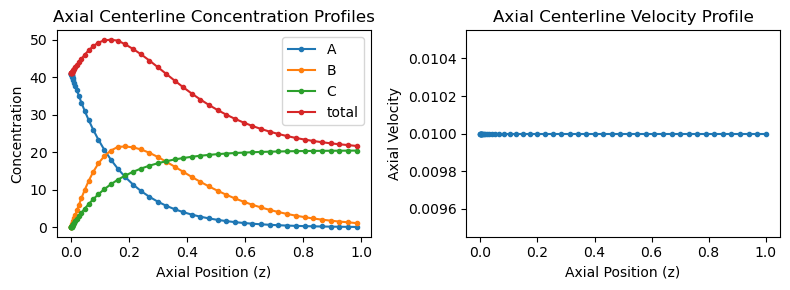

In [44]:
# Initialize the column model with the specified parameters, and boundary conditions
column_model = ConvectionDiffusionReaction2D(
    init_params=init_params_column,    # Initialize parameters using the init_params_column function
    set_bc=set_bc_column               # Set boundary conditions using the set_bc_column function
)

# Solve the column model to find the steady-state solution with column_model.dt = np.inf
column_model.solve()

# Plot the 2D concentration fields for each component in the model
plot_model_2D(column_model)
plot_axial_profile(column_model)


### Example: Solving the Column Model with Flow Coupling

This example demonstrates how to compute the solution for a column reactor model with flow coupling. The model is configured to simulate the interaction between flow dynamics and reaction kinetics. Key parameters such as the maximum number of function evaluations, molar masses of species, and viscosity are defined to capture the coupled behavior of the system. The model solves for the steady-state or transient behavior and provides visualization of the concentration fields, axial velocity, and pressure profiles along the length of the column. This approach offers a comprehensive analysis of the reactor's performance under coupled flow and reaction conditions.

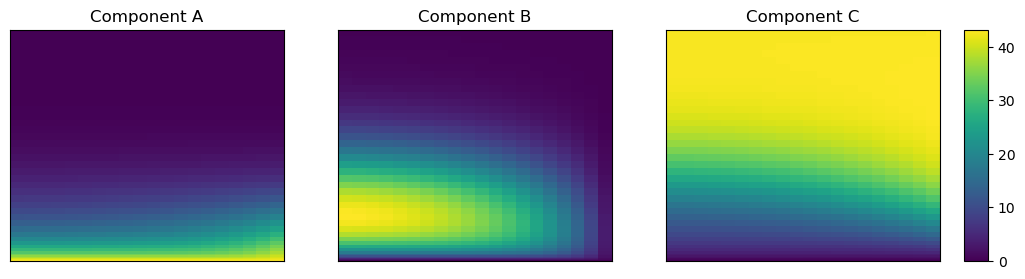

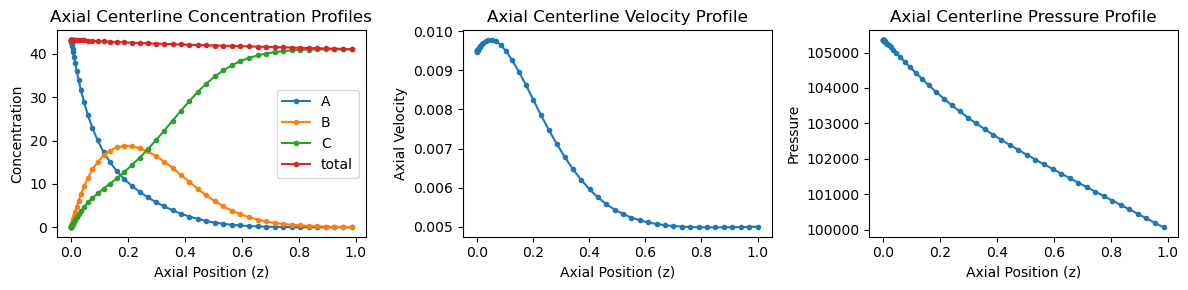

In [55]:
def init_params_flow_coupling(model):
    """
    Initialize parameters for the flow coupling model.
    
    Parameters:
    - model: The FlowCoupling model instance.
    """
    model.rm.maxfev = 5  # Set the maximum number of function evaluations in the reactor model
    model.maxfev = 10    # Set the maximum number of iterations within a time step for the flow coupling model
    model.molar_mass = [[[34.016e-3, 18.016e-3, 32.00e-3]]]  # Molar masses of the species in kg/mol
    model.visc = 1.0e-3  # Dynamic viscosity in Pa.s (Pascal-second)
    #model.is_mobile = [0,2] 

# Initialize the column model with flow coupling, using the FlowCoupling class
# The init_params_flow_coupling function is used to initialize additional parameters for pressure and velocity
column_model_with_flow_coupling = FlowCoupling(column_model, init_params=init_params_flow_coupling)

# Solve the column model with flow coupling
column_model_with_flow_coupling.solve()

# Plot the 2D concentration fields for each component in the model
plot_model_2D(column_model_with_flow_coupling.rm)

# Plot axial profiles for concentrations, axial velocity, and pressure (if available)
plot_axial_profile(column_model_with_flow_coupling)